# Flow matching posterior estimation

This tutorial demonstrates how to perform flow matching posterior estimation (FMPE) with LAMPE.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import zuko

from itertools import islice
from lampe.data import JointLoader
from lampe.inference import FMPE, FMPELoss
from lampe.plots import corner, mark_point, nice_rc
from lampe.utils import GDStep
from tqdm import trange

## Simulator

In [2]:
LABELS = [r'$\theta_1$', r'$\theta_2$', r'$\theta_3$']
LOWER = -torch.ones(3)
UPPER = torch.ones(3)

prior = zuko.distributions.BoxUniform(LOWER, UPPER)

def simulator(theta: torch.Tensor) -> torch.Tensor:
    x = torch.stack([
        theta[..., 0] + theta[..., 1] * theta[..., 2],
        theta[..., 0] * theta[..., 1] + theta[..., 2],
    ], dim=-1)

    return x + 0.05 * torch.randn_like(x)

theta = prior.sample()
x = simulator(theta)

print(theta, x, sep='\n')

tensor([ 0.5081, -0.7862,  0.8766])
tensor([-0.2001,  0.4426])


In [3]:
loader = JointLoader(prior, simulator, batch_size=256, vectorized=True)

## Training

The principle of flow matching posterior estimation (FMPE) is to train a regression network $v_\phi(\theta, x, t)$ to match a vector field inducing a normalizing flow between the posterior distribution $p(\theta | x)$ and a standard Gaussian distribution $\mathcal{N}(0, I)$. We use the [`FMPE`](lampe.inference.fmpe.FMPE) class to create a regression network adapted to the simulator's input and output sizes.

In [4]:
estimator = FMPE(3, 2, hidden_features=[64] * 5, activation=nn.ELU)
estimator

FMPE(
  (net): MLP(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=64, out_features=3, bias=True)
  )
)

Then, we train our regressor using a standard neural network training routine.

In [5]:
loss = FMPELoss(estimator)
optimizer = optim.Adam(estimator.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 128)
step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping

estimator.train()

for epoch in (bar := trange(128, unit='epoch')):
    losses = []

    for theta, x in islice(loader, 256):  # 256 batches per epoch
        losses.append(step(loss(theta, x)))

    bar.set_postfix(loss=torch.stack(losses).mean().item())

100%|██████████| 128/128 [01:00<00:00,  2.10epoch/s, loss=0.341]


## Inference

Now that we have an estimator of the vector field, we can sample from the normalizing flow $p_\phi(\theta | x)$ it induces.

In [6]:
theta_star = prior.sample()
x_star = simulator(theta_star)

estimator.eval()

with torch.no_grad():
    log_p = estimator.flow(x_star).log_prob(theta_star)
    samples = estimator.flow(x_star).sample((2**14,))

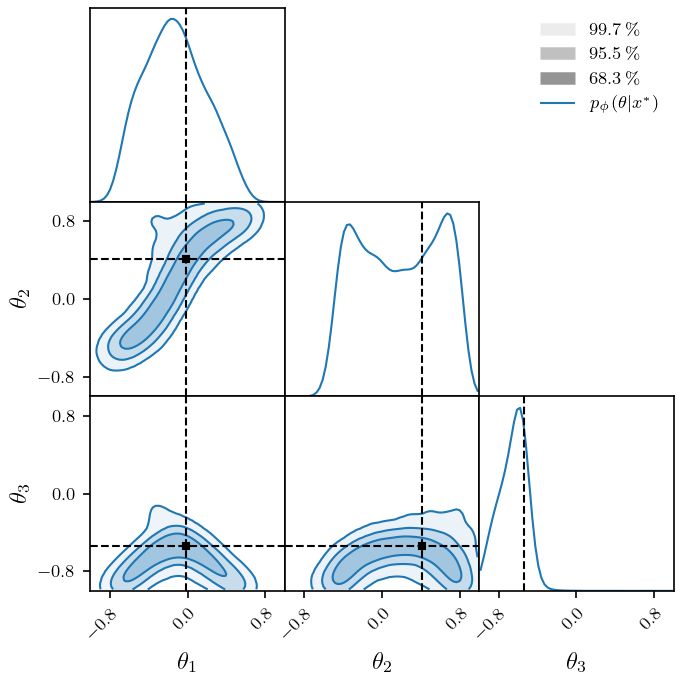

In [7]:
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

fig = corner(
    samples,
    smooth=2,
    domain=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*)$',
    figsize=(4.8, 4.8),
)

mark_point(fig, theta_star)